# Approximating average fluorescence over an ROI with a Gaussian

We'd like to know how well the Gaussian noise approximation holds up as the number of pixels approaches 0.
We assume a Poisson distribution of expected photon count $\lambda$ per pixel, with a Gaussian-distributed noise on top corresponding to electronic measurement noise.

$$ x \sim \text{Pois}(\lambda) $$
$$ y \sim \mathcal{N}(x, \sigma)$$

For ease of visualization, we convolve an imagined continuous version of the Poisson distribution with a Gaussian of width $\sigma$.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.stats import norm, poisson

int gauss 0.9981029012016058
int poisson 0.9469330144037739
int p_y 0.9308867579702512


[Text(0.5, 1.0, 'p(y)'), Text(0.5, 0, 'y')]

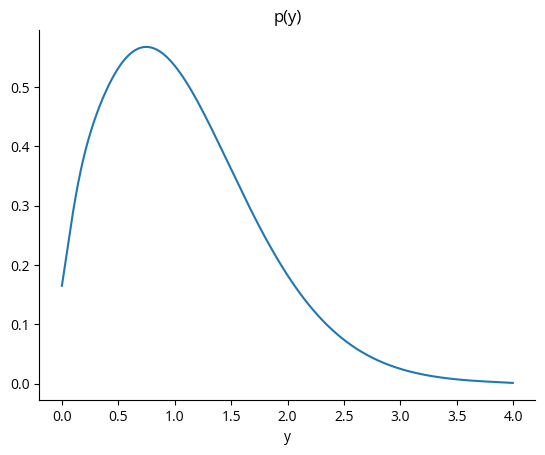

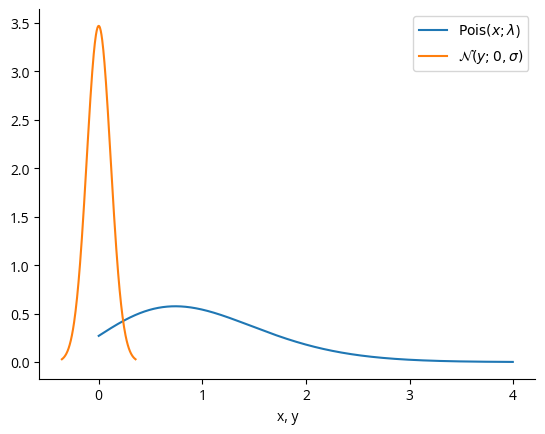

In [2]:
def poisson_vec(x, lam):
    return np.exp(-lam) * lam**x / factorial(x)

def p(n=1, lam=1, sigma_gauss=0.23, debug=False):
    sigma_gauss /= n
    gauss_range = np.linspace(
        norm.ppf(.001, loc=0, scale=sigma_gauss),
        norm.ppf(.999, loc=0, scale=sigma_gauss),
        200
    )
    dy = np.diff(gauss_range)[0]
    gauss_noise = norm.pdf(gauss_range, loc=0, scale=sigma_gauss)

    y = np.arange(
        poisson.ppf(.001, lam * n),
        poisson.ppf(.999, lam * n),
        dy * n
    )
    poisson_noise = poisson_vec(y, lam * n)
    y /= n
    poisson_noise *= n
    assert np.isclose(dy, np.diff(y)[0])

    p_y = np.convolve(poisson_noise, gauss_noise, mode='same') * dy

    if debug:
        fig, ax = plt.subplots()
        ax.plot(y, poisson_noise, label='$\mathrm{Pois}(x; \lambda$)')
        ax.plot(gauss_range, gauss_noise, label='$\mathcal{N}(y; 0, \sigma)$')
        ax.set(xlabel='x, y')
        ax.legend()
        print('int gauss', np.sum(gauss_noise) * dy)
        print('int poisson', np.sum(poisson_noise) * dy)
        print('int p_y', np.sum(p_y) * dy)
        
    return y, p_y

fig, ax = plt.subplots()
ax.plot(*p(n=2, debug=True))
ax.set(title='p(y)', xlabel='y')

/tmp/ipykernel_11747/2290709350.py:2: RuntimeWarning: overflow encountered in power
  return np.exp(-lam) * lam**x / factorial(x)
/tmp/ipykernel_11747/2290709350.py:2: RuntimeWarning: invalid value encountered in divide
  return np.exp(-lam) * lam**x / factorial(x)


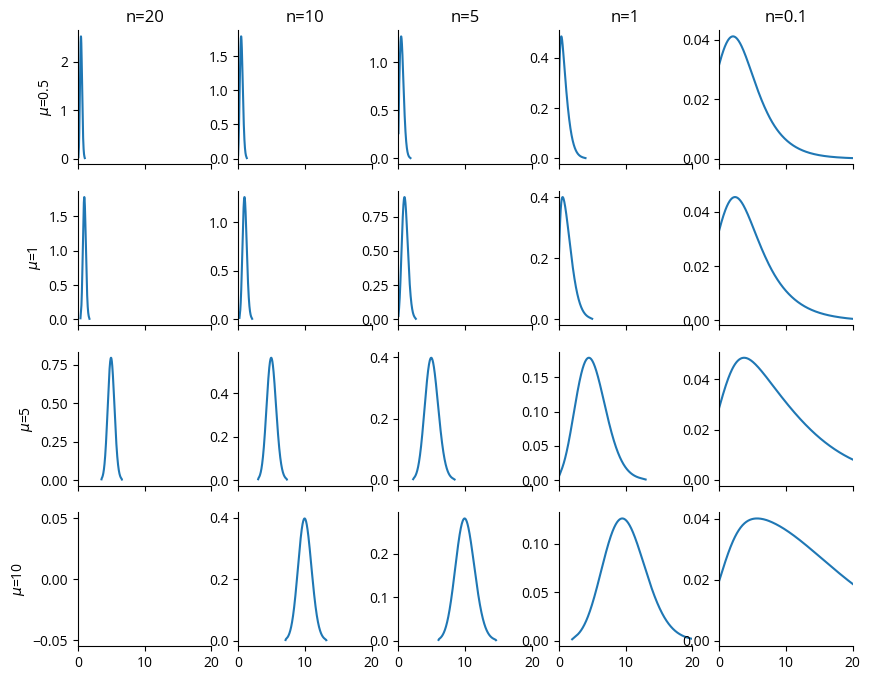

In [3]:
lams = [.5, 1, 5, 10]
nn = [20, 10, 5, 1, .1]
fig, axs = plt.subplots(len(lams), len(nn), figsize=(10, 2*len(lams)), sharey=False, sharex=True)
for lam, ax_row in zip(lams, axs):
    for n, ax in zip(nn, ax_row):
        ax.plot(*p(n=n, lam=lam))
        ax.set_xlim(0, 20)
        # ax.set_ylim(0, 0.4)
for n, ax in zip(nn, axs[0]):
    ax.set_title(f'n={n}')
for lam, ax in zip(lams, axs[:, 0]):
    ax.set(ylabel=f'$\mu$={lam}')

The conclusion I draw from this is that when photon counts $\lambda$ are high (considerably over one), a Gaussian does okay until you get down to one pixel.
But what about when $\lambda$ is low, corresponding to a neuron with a low signal (e.g., low calcium levels)?
We assume that neurons with high noise levels (few visible pixels) would be thrown out by an SNR threshold, so the failure to capture the skewed Poisson shape shouldn't be a problem.
This might correspond to throwing out neurons with a small ROI in a real experiment.

To capture the dependence of variance on the number of pixels, we can use the fact that both the Gaussian and Poisson distributions have standard deviation $\sigma$ that vary with $1/\sqrt{N}$.


Let's see what this looks like combined with the dropoff in pixel number with distance from the plane of imaging.
Since $\sigma_\text{noise} \propto 1/\sqrt{N}$, 

$$ \text{SNR} \propto \frac{1}{\sigma_\text{noise}} \propto \sqrt{N} $$

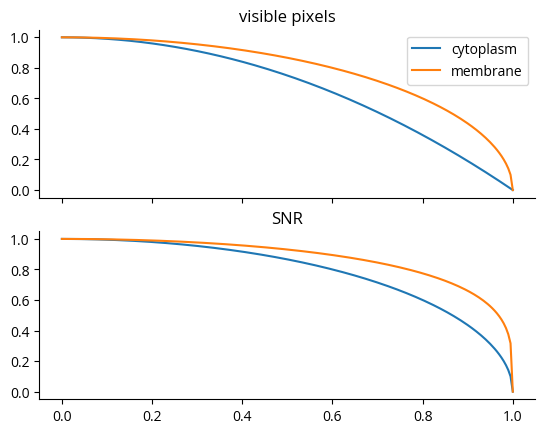

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
d = np.linspace(0, 1, 200)
soma_radius = 1
r_soma_visible = np.sqrt(soma_radius**2 - d**2)
ax1.plot(d, (r_soma_visible / soma_radius) ** 2, label='cytoplasm')
ax1.plot(d, (r_soma_visible / soma_radius), label='membrane')
ax1.set(title='visible pixels')
ax1.legend()

ax2.plot(d, (r_soma_visible / soma_radius), label='cytoplasm')
ax2.plot(d, (r_soma_visible / soma_radius) ** .5, label='membrane')
ax2.set(title='SNR');
